In [1]:
from sklearn import cluster, datasets, mixture
noisy_moons = datasets.make_moons(n_samples=500, noise=.11)


In [24]:
import numpy as np
import numpy.linalg as LA
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm
from scipy.stats import multivariate_normal
from numpy import random
plt.style.use('seaborn-white')
data, label = noisy_moons
PI = np.pi
Exp = np.exp
from math import log

In [3]:
from tabulate import tabulate
def plotTable(clms, clmDataHeadears, alignSize):
  data = []
  
  for i in range(len(clms[list(clms.keys())[0]])):
      dataElement = []
      for key in clms.keys():
          dataElement.append(clms[key][i])
      data.append(dataElement)
      
  print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                  colalign=["center"]*alignSize))

In [4]:
def est_moments(data_set):
  mu = np.sum(data_set, axis = 0)/len(data_set)
  cov = np.zeros([len(mu),len(mu)])
  for data in data_set:
    cov += (1/len(data_set)**2)*np.matmul(data - mu, (data - mu).T)
  return mu, cov
  

In [8]:
def guassian_dist(X, mean , cov):
  k = len(cov)
  f= (2*PI)**(-k/2)*(LA.det(cov)**(-0.5))*Exp(-0.5*np.matmul(np.matmul((X - mean).T, LA.inv(cov)),(X - mean)))
  return f 

In [10]:
classes = np.unique(label)
print("Classes: ",classes)
mu_gaussian = []
cov_gaussian = []
for c in classes:
  data_per_class = data[label==c]
  mu_tmp = np.mean(data_per_class, axis = 0)
  cov_tmp = np.cov(data_per_class.T)
  alpha = 0
  cov_tmp = cov_tmp + alpha*np.identity(len(cov_tmp))
  mu_gaussian.append(mu_tmp)
  cov_gaussian.append(cov_tmp)
  print("*******")
  print("Class{0} Expected Value:{1}".format(c,mu_tmp))
  print("Class{0} Cov Matrix :{1}".format(c,cov_tmp))


Classes:  [0 1]
*******
Class0 Expected Value:[-0.00428828  0.63406334]
Class0 Cov Matrix :[[0.49639922 0.00303324]
 [0.00303324 0.10889818]]
*******
Class1 Expected Value:[ 0.99784361 -0.1431314 ]
Class1 Cov Matrix :[[0.52601838 0.00075741]
 [0.00075741 0.1072737 ]]


In [11]:
def guassian_contours(mean, cov, ax):
  if cov.shape == (2,2):
    U, S, Vt = LA.svd(cov)
    ang = np.arctan2(U[1][0], U[0][0])*180/PI
    w,h = 2*np.sqrt(S)
  else:
    angle = 0
    w, h = 2*np.sqrt(cov)
  for k in range(1,4):
     ellipse = Ellipse(mean, width = k*w, height = k*h, angle = ang, alpha = 0.2 , color = 'b')
     ax.add_patch(ellipse)
  



In [12]:
def plot_data_dist(data, mean_mat, cov_tmp_mat, ax, arr = False):
  ax = ax or plt.gca()
  ax.scatter(data[:,0], data[:,1], color = 'r')
  if (arr):
    guassian_contours(mean_mat, cov_tmp_mat, ax)
  else:
    for mean, cov_tmp in zip(mean_mat, cov_tmp_mat):
        guassian_contours(mean, cov_tmp, ax)  

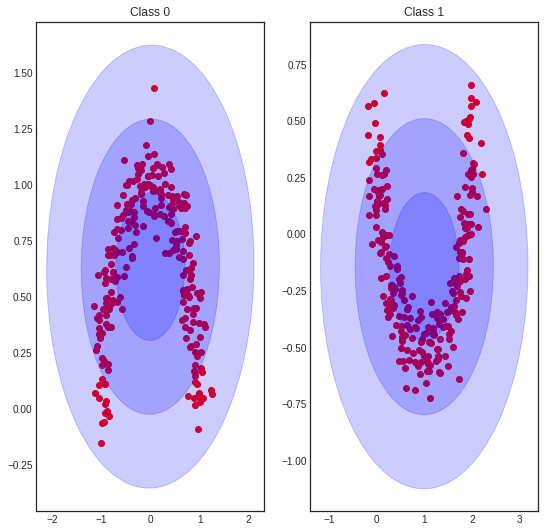

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(9, 9))
for c,mu_tmp,cov_tmp,ax in zip(classes, mu_gaussian, cov_gaussian,axs):
  mean_data = np.mean(data[label==c],axis = 0)
  plot_data_dist(data[label == c], mu_tmp, cov_tmp ,ax, arr = True)
  ax.set_title('Class ' + str(c))
plt.show()
plt.close()


In [22]:
r = 3
plotTable({1:["Mean ", "Cov Matrix"], 2:[np.round(mu_gaussian[0], decimals =r), np.round(cov_gaussian[0], decimals =r)],
           3:[np.round(mu_gaussian[1], decimals = r),np.round(cov_gaussian[1], decimals = r)]}, 
          ['Param Name', 'Class1', 'Class2'], 3)

╒══════════════╤═════════════════╤═════════════════╕
│  Param Name  │     Class1      │     Class2      │
╞══════════════╪═════════════════╪═════════════════╡
│     Mean     │ [-0.004  0.634] │ [ 0.998 -0.143] │
├──────────────┼─────────────────┼─────────────────┤
│  Cov Matrix  │ [[0.496 0.003]  │ [[0.526 0.001]  │
│              │  [0.003 0.109]] │  [0.001 0.107]] │
╘══════════════╧═════════════════╧═════════════════╛


In [40]:
class GMM():
  def __init__(self, n_components):
    self.__alpha = 1/n_components
    self.__mu = []
    self.__sigma = []
    self.__n_components = n_components
  def __calc_P(self, data_set):
    p = np.zeros((self.__n_components, len(data_set)))
    for j in range(self.__n_components):
      for i in range(len(data_set)):
        p[j,i] = guassian_dist(data_set[i,:], self.__mu[j,:],  self.__sigma[j])
      p[j,:] = self.__alpha[j]*p[j,:]
    norm_fact = np.sum(p, axis = 0)
    for i in range(np.shape(p)[1]):
      p[:,i] = p[:,i]/norm_fact[i]
    return p
  def __update_mu(self, p, data_set):
    mu_tmp = np.matmul(p, data_set)
    normal_facts = np.sum(p,axis = 1)
    for j in range(len(mu_tmp)):
      mu_tmp[j,:] = mu_tmp[j,:]/normal_facts[j]
    self.__mu = mu_tmp
  def __update_sigma(self, p, data_set):
      coef = 10**(-4)
      normal_facts = np.sum(p,axis = 1)
      for j in range(len(self.__sigma)):
        sigma = np.zeros(np.shape(self.__sigma[0]))
        for i in range(len(data_set)):
          x_bar = data_set[i,:] - self.__mu[j,:]
          sigma += p[j][i]*np.tensordot(x_bar, x_bar, axes=0)
        sigma = sigma/normal_facts[j]
        self.__sigma[j] = sigma + coef*np.eye(len(sigma))
    

  def __update_params(self, data_set):
      n_components = self.__n_components
      p = self.__calc_P(data_set)
      self.__alpha = np.sum(p, axis = 1)/len(data_set)
      self.__update_mu(p, data_set)
      self.__update_sigma(p, data_set)

  def __stop_cond(self, cnt, LIMIT):
      if(cnt>LIMIT):
        return True
  def __calculate_aic(self, likelihood, num_params):
    aic = 2 * num_params - 2*log(likelihood) 
    return aic

# calculate bic for regression
  def __calculate_bic(self,likelihood, num_params, sample_size):
      bic = log(sample_size)*num_params - 2*log(likelihood)
      return bic
  def __calc_likelihood(self, data_set, mu, sigma, alpha):
    sum = 0
    for i in range(len(data_set)):
      for j in range(len(mu)):
        sum += alpha[j]*guassian_dist(data_set[i,:], mu[j,:], sigma[j])
    return sum
  def train_model(self, data_set):
    LIMIT = 100
    self.__alpha = np.ones(self.__n_components)/self.__n_components; 
    self.__mu = random.rand(self.__n_components, np.shape(data)[1]); init_sigma = [] 
    for i in range(self.__n_components):
        init_sigma.append(5*random.rand()*np.identity(np.shape(data_set)[1]))
    self.__sigma = init_sigma
    cnt = 0
    while True:
      self.__update_params(data_set)
      if self.__stop_cond(cnt, LIMIT):
         break 
      cnt +=1

    mu = self.__mu; sigma = self.__sigma; alpha = self.__alpha
    l = self.__calc_likelihood(data_set, mu, sigma, alpha)
    aic = self.__calculate_aic(l,len(mu)*2+len(mu)*4); bic = self.__calculate_bic(l,len(mu)*2+len(mu)*4, len(data_set))
    return self.__alpha, self.__mu, self.__sigma, aic, bic

In [ ]:
n_components = 3
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
for c, ax in zip(classes, axs):
  gmm = GMM(n_components)
  data_samp = data[label==c]
  alpha, mu, sigma, aic_tmp, bic_tmp = gmm.train_model(data_samp)
  plot_data_dist(data[label == c], mu, sigma ,ax)
  ax.set_title("Class "+str(c))
plt.show()

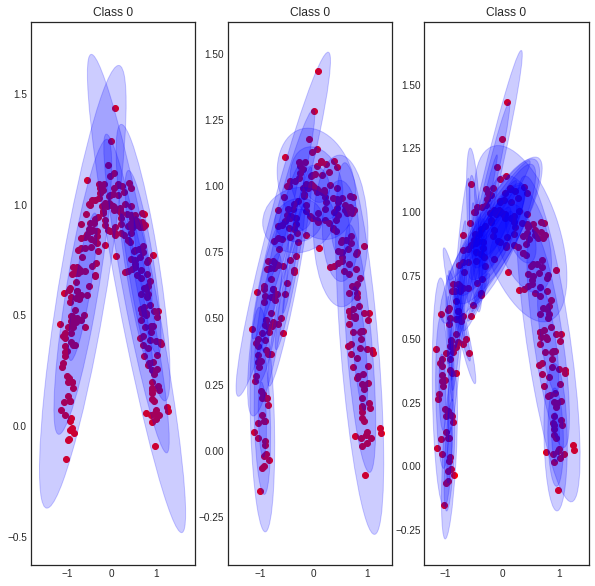

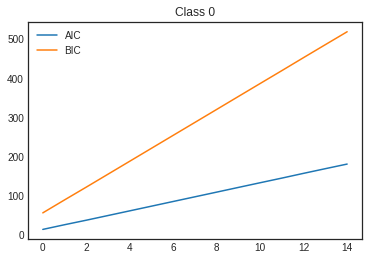

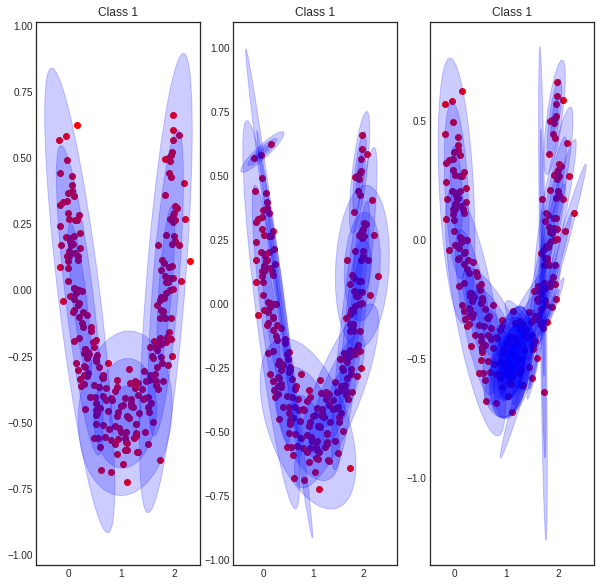

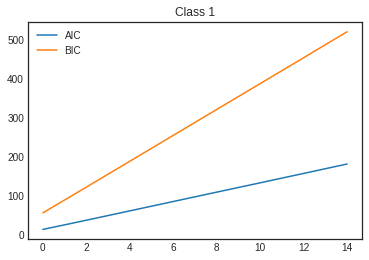

In [41]:
ind = [3,8,16]
for c in classes:
      data_samp = data[label==c]
      aic = []; bic = []; i = 0
      fig, axs = plt.subplots(1, 3, figsize=(10, 10))
      for n in range(2,17):
        gmm = GMM(n)
        alpha, mu, sigma, aic_tmp, bic_tmp = gmm.train_model(data_samp)
        aic.append(aic_tmp)
        bic.append(bic_tmp)
        if n==ind[i]:
            plot_data_dist(data[label == c], mu, sigma ,axs[i])
            axs[i].set_title("Class "+str(c))
            i = i+1
      plt.show(); plt.close()
      plt.plot(aic, label = 'AIC'); plt.plot(bic, label = "BIC")
      plt.title("Class "+str(c)); plt.legend()
      plt.show();  plt.close()